In [215]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', size=12)
plt.rc('axes', labelsize=18)
plt.rc('lines', linewidth=2)

## Estimating regression models with unknown break-points

Tentative de traduction pour un physicien de l'article: "Estimating regression models with unknown break-points" de Vito M. R. Muggeo (2003) [[voir le pdf](https://www.researchgate.net/profile/Vito_Muggeo/publication/10567491_Estimating_Regression_Models_with_Unknown_Break-Points/links/5a34fda2aca27247eddd201e/Estimating-Regression-Models-with-Unknown-Break-Points.pdf)].

### The simple model (one break-point)

On a une mesure $(X_i, Y_i)$, que l'on souhaite estimer par une fonction non linéaire de la forme:

$$
f_0(t) = a + b\cdot t + c\cdot ramp( t - t_0 )
$$

$a$, $b$, $c$ et $t_0$ sont les constantes que l'ont cherche à estimer.

La fonction $ramp(  t - t_0 )$ est non-linéaire:
$$
ramp(  t - t_0 ) = max( t - t_0 ,\, 0 )
$$

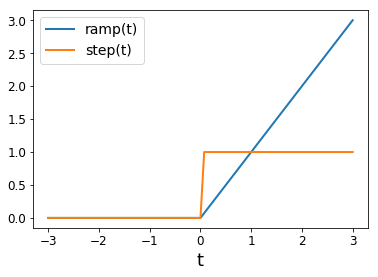

In [216]:
ramp = lambda u: np.maximum( u, 0 )
step = lambda u:  ( u > 0 ).astype(float)

# plot
t = np.linspace( -3, 3, 83 )
plt.plot( t, ramp(t), label='ramp(t)' )
plt.plot( t, step(t), label='step(t)' );
plt.xlabel('t'); plt.legend(fontsize=14);

Les paramètres $a$, $b$ et $c$ sont linéaires dans l'équation. Ils peuvent donc être estimés avec la méthode des moindres carrés. En revanche, $t_0$ est non linéaire. L'idée est de calculer la même fonction, avec une valeur proche $t_1 = t_0 + dt$ et d'effectuer un développement de Taylor au 1er ordre. 

Avec des notations générales:
$$
ramp(x - dx) \sim ramp(x) + dx \, \left. \frac{d\, ramp(u)}{du}  \right|_{x - dx}
$$

Et avec les notations du problème, le développement en $t - t_0$ avec $dt=t_1 - t_0$ permet d'écrire:

$$
ramp(t - t_1) \sim ramp(t - t_{0}) + (t_0 - t_{1}) \left. \frac{d\, ramp(u)}{du} \right|_{t - t_{0}}
$$

La derivée d'une rampe est une marche:
$$
\left. \frac{d\,ramp(u)}{du}\right)_{t-t_{0}} 
= step( t - t_{0} ) = Heaviside( t - t_{0} ) 
$$

Une second fonction théorique est alors obtenue:
$$
f_1(t) = a + b\,t + c\cdot ramp( t - t_{0} ) + c (t_0 - t_{1})\cdot  step( t - t_{0} ) 
$$

En posant $d = c \, (t_0 - t_{1})$, et en utilisant cette fonction pour effectué le fit, la valeur de $t_1$ peut être itérativement estimée.

$$
t_1 = t_0 - \frac{d}{c} 
$$

"the process is iterated until possible convergence, which is not, in general, guaranteed"

- Critère de convergence: $t_1 - t_0 < pas\,de\, temps$

- Le choix de $t_0$ initial n'est pas discuté.

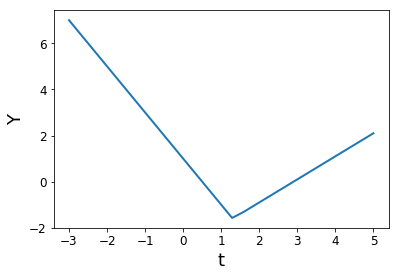

In [217]:
# fonction test 
t = np.linspace( -3, 5, 29 )
Y = 3*ramp( t - 1.3 )  - 2*t + 1

# plot
plt.plot( t, Y ); plt.xlabel('t'); plt.ylabel('Y');

La fonction `lstsq` (least-squares) de `numpy` est utilisée ([doc](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html)). 

Résout l'equation $A \vec p = \vec Y$ en calculant le vecteur $\vec p$ qui minimise la norme $|| Y - A p ||^2$. 

La matrice $A$ est de la forme suivante:
$$
A = \begin{bmatrix}
    1       & 0 & ramp(0-t_0) & step(0-t_0)  \\
    1       & 1 & ramp(1-t_0) & step(1-t_0) \\
    1       & 2 & ramp(2-t_0) & step(2-t_0)  \\
    \dots   & \dots & \dots & \dots 
\end{bmatrix}
$$
La solution est le vecteur paramètre: $p = [a\, b\,c \, d]$

In [218]:
from numpy.linalg import lstsq

t0=  -1
t1=  0.401002506266
t2=  1.00614439324
t3=  1.29634171265
t4=  1.3
t5=  1.3


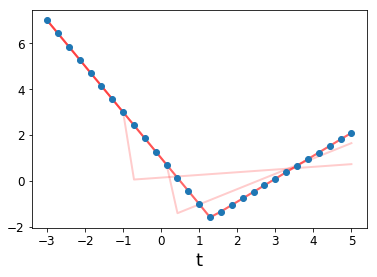

In [219]:
t0 = -1
X = t
ones = np.ones_like(X)
for k in range( 6 ):
    print('t%i= '%k, t0)
    
    R, S = ramp( X - t0 ), step( X - t0 )
    A = np.array([ ones, X,  R, S  ])
    sol = lstsq(A.transpose(), Y)
    a, b, c, d = sol[0]
    t1 = t0 - d/c
     
    # next iteration
    t0 = t1
    
    # plot
    plt.plot( t, ones*a + b*X + c*R + d*S, 'r', alpha=.2  )
    
    
plt.plot( t, Y, 'o' ); plt.xlabel('t');

## The multi-breakpoints case

La fonction théorique est maintenant:
$$
f_0(t) = a + b\,t + \sum_k^N c_{k}\, ramp( t - t_{k, 0} )
$$

De la même façon, le devellopement limité peut être effectué en sommant les contributions de chaques variables:
$$
ramp(t - t_{k, 1}) \sim ramp(t - t_{k, 0}) + (t_{k, 0} - t_{k, 1}) \left. \frac{d\, ramp(u)}{du} \right|_{t - t_{k, 0}} \\
\sim  ramp(t - t_{k, 0}) + (t_{k, 0} - t_{k, 1}) \,step(t - t_{k, 0})
$$

et
$$
f_1(t) = a + b\,t + \sum_k^N c_{k}\cdot ramp( t - t_{k, 0} ) + c_{k}(t_{k, 0} - t_{k, 1}) \cdot step(t - t_{k, 0})
$$

Si $d_k =  c_{k}(t_{k, 0} - t_{k, 1}) $, on retrouve les $N$ nouveaux temps avec:
$$
t_{k, 1} =  t_{k, 0 }- \frac{d_k}{c_k} 
$$

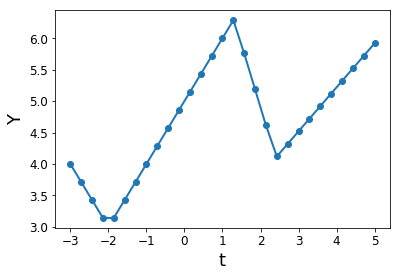

In [220]:
t = np.linspace( -3, 5, 29 )

Y = 1 - t + 2*ramp( t + 2 ) - 3*ramp( t - 1.3 )  + 2.7*ramp( t - 2.4 )
plt.plot( t, Y, '-o' ); plt.xlabel('t'); plt.ylabel('Y');

t0k=  [-1, 0, 4]
t1k=  [-1.4285714285714328, 0.57584505676799858, 3.2969618532415925]
t2k=  [-1.7728937728937726, 0.91817051802375171, 2.9089147637759631]
t3k=  [-1.9206349206349209, 1.1338624338624335, 2.5835866261398168]
t4k=  [-1.9999999999999996, 1.2863021751910637, 2.42005242463958]
t5k=  [-2.0000000000000009, 1.3000000000000009, 2.3999999999999999]
t6k=  [-2.0, 1.2999999999999994, 2.4000000000000008]


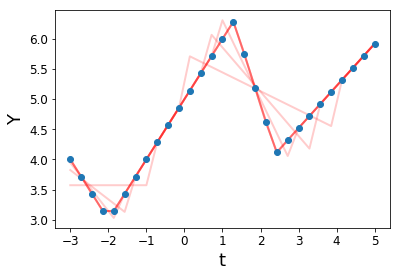

In [221]:
t0k = [-1, 0, 4]
X = t
ones = np.ones_like(X)

for i in range( 7 ):
    print('t%ik= '%i, t0k )
    Rk = [ramp( X - tk ) for tk in t0k ]
    Sk = [step( X - tk ) for tk in t0k ]
    A = np.array([ ones, X ] + Rk + Sk )
    sol = lstsq(A.transpose(), Y)
    params = list( sol[0] )
    
    # parameters identification
    a = params.pop(0)
    b = params.pop(0)
    ck = [ params.pop(0) for k in range(len(t0k)) ]
    dk = [ params.pop(0) for k in range(len(t0k)) ]
    t1k = [ t0 - d/c for t0, c, d in zip( t0k, ck, dk )   ]
  
    # next iteration
    t0k = t1k
    
    # plot
    sumRamp = np.sum( [ c*r for c, r in zip( ck, Rk ) ], axis=0 )
    sumStep = np.sum( [ d*s for d, s in zip( dk, Sk ) ], axis=0 )
    Y1 = ones*a + b*X + sumRamp + sumStep
    plt.plot( t, Y1, 'r', alpha=.2  )
    

plt.plot( t, Y, 'o' ); plt.xlabel('t'); plt.ylabel('Y');

_note:_ les coefficients correspondent aux changement de pente, ce ne sont pas directement les pentes

## La suite
- et avec une Gaussienne? une marche?
- avec des fonctions non coopérantes?